General DESI related packages

In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt

import specsim.quickspecsim as qspecsim
import specsim.instrument as inst
import specsim.source as src
import specsim.config as conf
import specsim.fiberloss as floss
import specsim.observation as obs
import specsim.simulator as sim
import specsim.atmosphere as atm

from desisim import io
from desisim import obs

import astropy.units as u
import astropy.table

Plot some of the instrument related figures

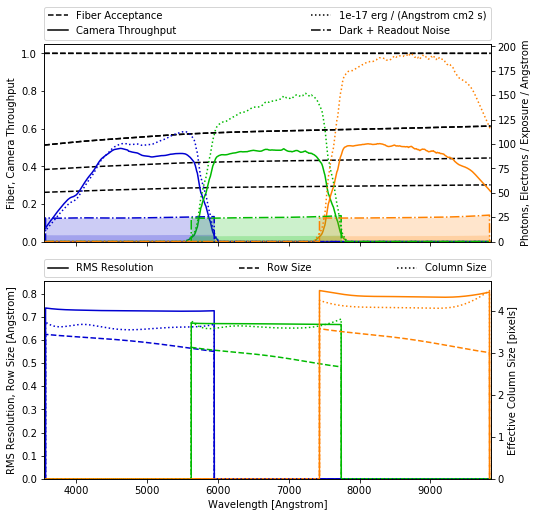

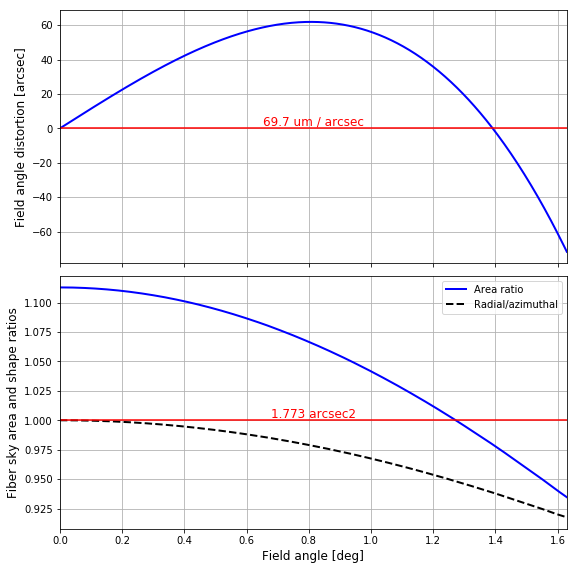

In [2]:
plt.clf()
fig1 = plt.figure(1,1)
c = specsim.config.load_config('desi')
i = specsim.instrument.initialize(c)
i.plot()
plt.show()
i.plot_field_distortion()
plt.show()

In [8]:
desi_configs = ['desi-blur', 'desi-blur-offset', 'desi-blur-offset-scale', 'desi-blur-offset-scale-stochastic']
config_path = '/home/tyapici/Projects/desi/examples/dithering/config/'
desi_models = {}

def desi_model(model):
    return sim.Simulator(config_path+model+'.yaml')

for config in desi_configs:
    desi_models[config] = desi_model(config)

In [11]:
def create_wlen_grid(num_wlen=11, desi=desi_models['desi-blur']):
    wavelength = desi.simulated['wavelength']
    wlen_unit = wavelength.unit
    return np.linspace(wavelength.data[0], wavelength.data[-1], num_wlen) * wlen_unit
wlen_grid = create_wlen_grid()

[ 3550.  4180.  4810.  5440.  6070.  6700.  7330.  7960.  8590.  9220.
  9850.] Angstrom


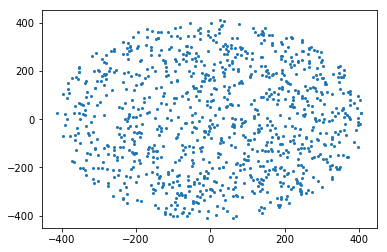

In [22]:
def generate_fiber_positions(nfiber=5000, seed=123, desi=desi_models['desi-blur']):
    gen = np.random.RandomState(seed)
    focal_r = (
        np.sqrt(gen.uniform(size=nfiber)) * desi.instrument.field_radius)
    phi = 2 * np.pi * gen.uniform(size=nfiber)
    return np.cos(phi) * focal_r, np.sin(phi) * focal_r

focal_x, focal_y = generate_fiber_positions(1000)
plt.plot(focal_x, focal_y, 'o', markersize=2)
plt.show()

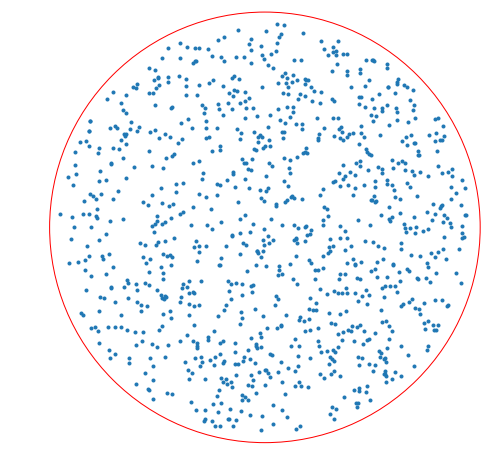

In [29]:
def plot_fiber_positions(save=None, desi=desi_models['desi-blur'], select=None):
    plt.figure(figsize=(8, 8))
    x, y = focal_x.to(u.mm).value, focal_y.to(u.mm).value
    plt.plot(x, y, '.')
    if select is not None:
        plt.scatter(x[select], y[select], s=100)
    r = 1.05 * desi.instrument.field_radius.to(u.mm).value
    plt.xlim(-1.01 * r, +1.01 * r)
    plt.ylim(-1.01 * r, +1.01 * r)
    plt.gca().set_aspect('equal', 'datalim')
    plt.gca().add_artist(plt.Circle((0, 0), r, color='r', fill=False))
    plt.axis('off')
    if save:
        plt.savefig(save)
    else:
        plt.show()
plot_fiber_positions()

In [37]:
def generate_sources(nsrc=5000, disk_fraction=1., bulge_fraction=0., vary='', seed=23):
    gen = np.random.RandomState(seed)
    varied = vary.split(',')
    source_fraction = np.tile([disk_fraction, bulge_fraction], (nsrc, 1))
    source_half_light_radius = np.tile([0.45, 1.0], (nsrc, 1))
    source_minor_major_axis_ratio = np.tile([1.0, 1.0], (nsrc, 1))
    if 'pa' in varied:
        source_position_angle = 360. * gen.uniform(size=(nsrc, 2))
    else:
        source_position_angle = np.tile([30., 30.], (nsrc, 1))
    return source_fraction, source_half_light_radius, source_minor_major_axis_ratio, source_position_angle

qsos = generate_sources(1000, 0., 0.)

In [39]:
calc = floss.GalsimFiberlossCalculator(desi_models['desi-blur'].instrument.fiber_diameter.to(u.um).value,
                                       wlen_grid.to(u.Angstrom).value,
                                       num_pixels=16, oversampling=32, moffat_beta=3.5)


In [55]:
def get_fiberloss(source_fraction, source_half_light_radius, source_minor_major_axis_ratio,
                  source_position_angle,
                  x=focal_x, y=focal_y, seeing=1.1*u.arcsec, desi=desi_models['desi-blur'], calc=calc):
    # Subtract instrumental PSF.
    #Jacoby = 0.219
    #seeing = 2.35482 * np.sqrt((seeing.to(u.arcsec).value/2.35482) ** 2 - Jacoby**2) * u.arcsec
    # Tabulate seeing.
    #desi.atmosphere.seeing_fwhm_ref = seeing
    seeing_fwhm = desi_models['desi-blur'].atmosphere.get_seeing_fwhm(wlen_grid).to(u.arcsec).value
    # Calculate optics.
    scale, blur, offset = desi_models['desi-blur'].instrument.get_focal_plane_optics(x, y, wlen_grid)
    # Do the fiberloss calculations.
    return calc.calculate(seeing_fwhm,
                          scale.to(u.um / u.arcsec).value, offset.to(u.um).value,
                          blur.to(u.um).value,
                          source_fraction, source_half_light_radius,
                          source_minor_major_axis_ratio, source_position_angle)

In [70]:
seeing_fwhm = desi_models['desi-blur'].atmosphere.get_seeing_fwhm(wlen_grid).to(u.arcsec).value
seeing=1.1*u.arcsec
Jacoby = 0.219
seeing = 2.35482 * np.sqrt((seeing.to(u.arcsec).value/2.35482) ** 2 - Jacoby**2) * u.arcsec
print(seeing_fwhm, seeing)
desi_models['desi-blur'].atmosphere.seeing_fwhm_ref = seeing
seeing_fwhm = desi_models['desi-blur'].atmosphere.get_seeing_fwhm(wlen_grid).to(u.arcsec).value
print(seeing_fwhm)
scale, blur, offset = desi_models['desi-blur'].instrument.get_focal_plane_optics(focal_x, focal_y, wlen_grid)
print("_-----_-----__--_____--_-----")
print(len(scale), len(blur), len(offset), len(focal_x))
print(len(wlen_grid), len(blur[1]))
print(blur[1])
print(offset[100]) # are all the offsets zero???

[ 1.09162739  1.05653731  1.02728531  1.00230596  0.98057847  0.96140225
  0.94427675  0.92883266  0.91479011  0.90193223  0.8900878 ] 0.9716211992113304 arcsec
[ 1.09162739  1.05653731  1.02728531  1.00230596  0.98057847  0.96140225
  0.94427675  0.92883266  0.91479011  0.90193223  0.8900878 ]
_-----_-----__--_____--_-----
1000 1000 1000 1000
11 11
[ 13.73606619  13.26975394  12.8183241   12.52715676  12.73675388
  13.25934258  13.77568641  14.13202169  14.26214555  14.26521942
  14.26827813] um
[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]] um


In [3]:
import numpy as np
import matplotlib.pyplot as plt
fl = floss.GalsimFiberlossCalculator(100, 10)
source_fraction = np.tile([1.0, 0.0], (1, 1))
source_half_light_radius = np.tile([0.45, 1.0], (1, 1))
source_minor_major_axis_ratio = np.tile([1.0, 1.0], (1, 1))
source_position_angle = np.tile([30., 30.], (1, 1))
source = fl.create_source(fractions=source_fraction[0], 
                          half_light_radius=source_half_light_radius[0], 
                          minor_major_axis_ratio=source_minor_major_axis_ratio[0],                                              
                          position_angle=source_position_angle[0])


(galsim.Exponential(scale_radius=0.26812095631996397))
galsim.Image(bounds=galsim.BoundsI(1,56,1,56), scale=0.08423268266482688)


/home/tyapici/anaconda/anaconda3/envs/desi/lib/python3.5/site-packages/galsim/deprecated/__init__.py:53: GalSimDeprecationWarning: (GalSimDeprecationWarning(...), "draw has been deprecated since GalSim version 1.1.  Use drawImage(..., method='no_pixel') instead.  Note: drawImage has different args than draw did.  Read the docs for the method keywords carefully.")
  warnings.warn(s, GalSimDeprecationWarning)
